<a href="https://colab.research.google.com/github/MudSnail/Land_Cover_Classification/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import base libraries
import pandas as pd
import numpy as np
import copy
import pickle
import cloudpickle

#Sklearn - Pipelines, Training
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler

#Classification Models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#Model metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

#misc
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Input Data, Combine and Subsample

In [3]:
#Read in CSVs
james_bay = pd.read_csv('/content/drive/MyDrive/james_bay_data.csv')
labrador = pd.read_csv('/content/drive/MyDrive/labrador_data.csv')
simcoe = pd.read_csv('/content/drive/MyDrive/simcoe_york_data.csv')

In [4]:
#List dataframes to add to james_bay
dfs = [labrador, simcoe]

#Merged data
merged_data = james_bay.append(dfs)

#Print shape and check new data
print(merged_data.shape)
merged_data.head()

(8917500, 13)


,B01,B06,B11,B07,B05,B03,B09,B12,B8A,B04,B08,B02,Class
0,0.0055,0.0017,0.0009,0.0016,0.0026,0.0056,0.0001,0.0009,0.0003,0.0032,0.0012,0.0114,0
1,0.0054,0.0020,0.0009,0.0017,0.0021,0.0060,0.0001,0.0005,0.0007,0.0028,0.0014,0.0115,0
2,0.0058,0.0018,0.0007,0.0016,0.0028,0.0060,0.0001,0.0008,0.0007,0.0030,0.0012,0.0124,0
3,0.0057,0.0016,0.0007,0.0016,0.0023,0.0058,0.0001,0.0012,0.0006,0.0031,0.0011,0.0119,0
4,0.0066,0.0013,0.0008,0.0020,0.0029,0.0059,0.0001,0.0008,0.0005,0.0030,0.0014,0.0115,0


In [5]:
#Drop Class = 0 (null values, which equate to 18)
merged_data = merged_data[merged_data.Class != 0]

#Double check value counts
merged_data.Class.value_counts()

15    2836714
18    1050988
1      677877
5      666952
16     646870
13     612009
8      575175
17     512930
12     415493
6      378274
2      151560
11     135890
14      94850
10      86338
19      74619
Name: Class, dtype: int64

In [6]:
#SubSample ~70 000 for each class
sample = merged_data.groupby('Class').apply(lambda x: x.sample(n=70000)).reset_index(drop=True)
sample.head(4)

,B01,B06,B11,B07,B05,B03,B09,B12,B8A,B04,B08,B02,Class
0,0.0111,0.1854,0.1356,0.2248,0.0805,0.0440,0.2335,0.0641,0.2665,0.0426,0.2583,0.0207,1
1,0.0205,0.1824,0.1537,0.2040,0.1128,0.0543,0.2324,0.0823,0.2266,0.0591,0.2213,0.0368,1
2,0.0160,0.1272,0.1025,0.1449,0.0640,0.0334,0.1651,0.0543,0.1601,0.0251,0.1517,0.0212,1
3,0.0109,0.1250,0.0976,0.1408,0.0684,0.0337,0.1552,0.0502,0.1530,0.0282,0.1482,0.0227,1


# EDA - Checking Each Layer per Class

In [11]:
def plot_class_distributions(x, y, z):
  """
  Input:
  x - the specific NRCAN Land Classification
  y - the plot's 1st x lim
  z - the plot's 2nd x lim

  Output: Skewness distribution plots per each layer for the class specified
  """
  #Select Class and drop column
  selected_class = sample.loc[sample['Class'] == x]
  selected_class = sample.drop('Class', axis = 1)

  #exctract column values, identify number of columns and rows
  l = selected_class.columns.values 
  number_of_columns=12
  number_of_rows = len(l)-1/number_of_columns

  #plot distribution skewness figure for each column
  plt.figure(figsize=(2*number_of_columns,5*number_of_rows))
  for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.distplot(selected_class[l[i]],kde=True)
    #Set x axis limits
    plt.xlim([y,z]) 

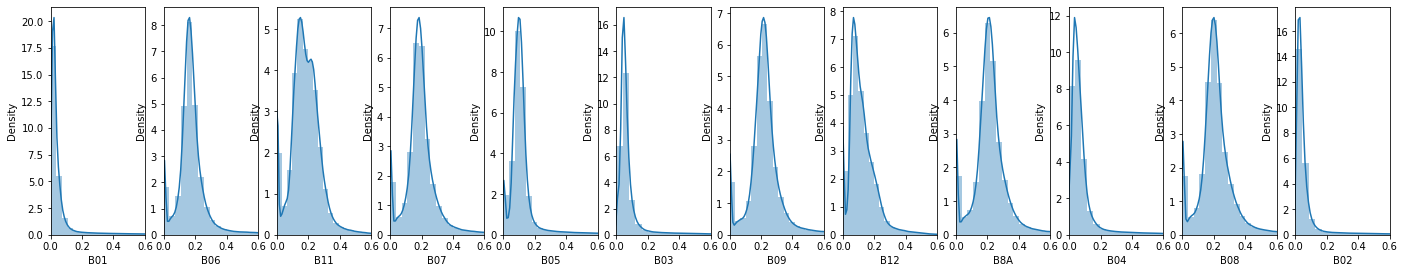

In [30]:
#Check skewness of Class 1
plot_class_distributions(1,0,0.6)

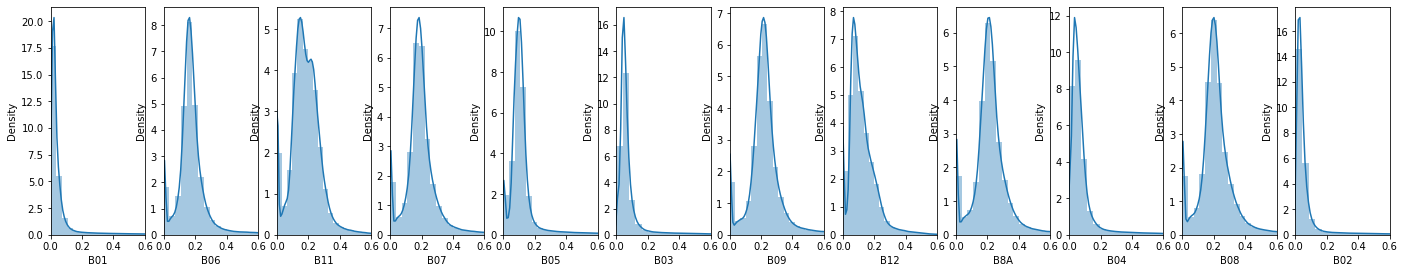

In [29]:
#Check skewness of Class 2
plot_class_distributions(2,0,0.6)

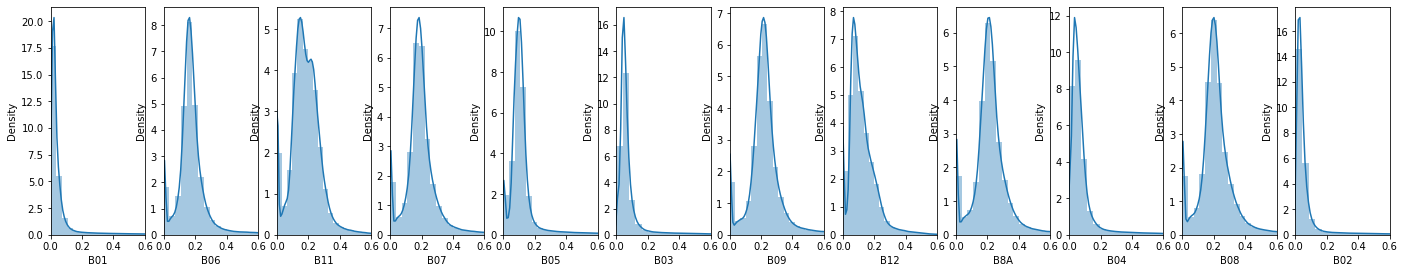

In [15]:
#Check skewness of Class 5
plot_class_distributions(5,0,0.6)

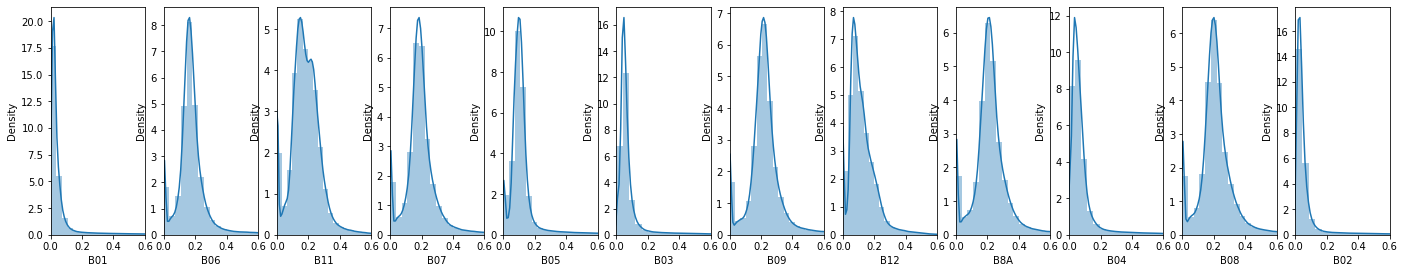

In [16]:
#Check skewness of Class 6
plot_class_distributions(6,0,0.6)

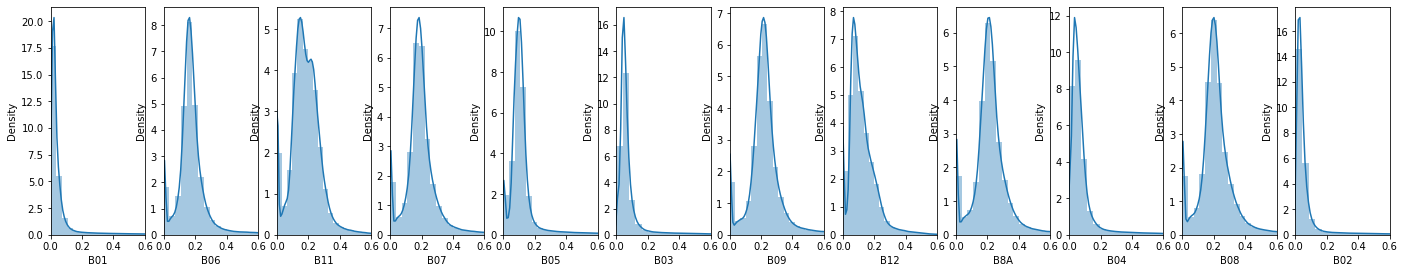

In [17]:
#Check skewness of Class 8
plot_class_distributions(8,0,0.6)

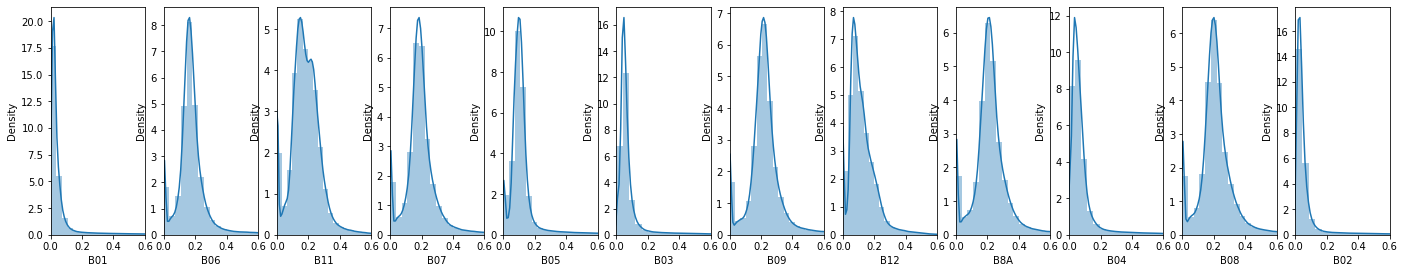

In [18]:
#Check skewness of Class 10
plot_class_distributions(10,0,0.6)

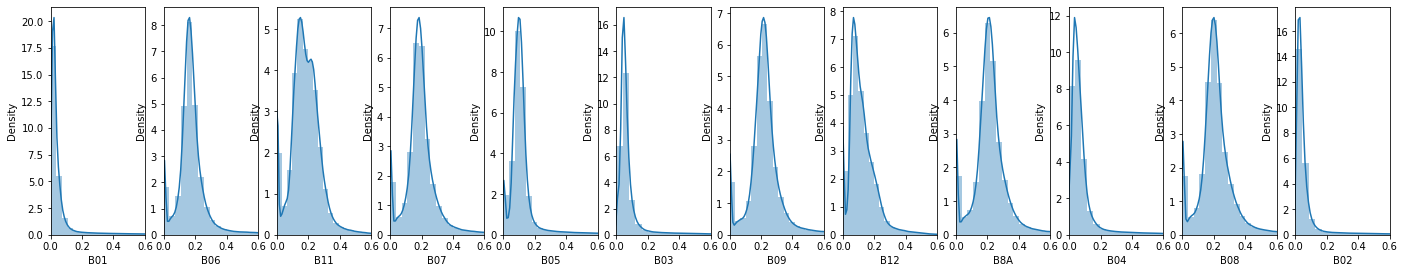

In [19]:
#Check skewness of Class 11
plot_class_distributions(11,0, 0.6)

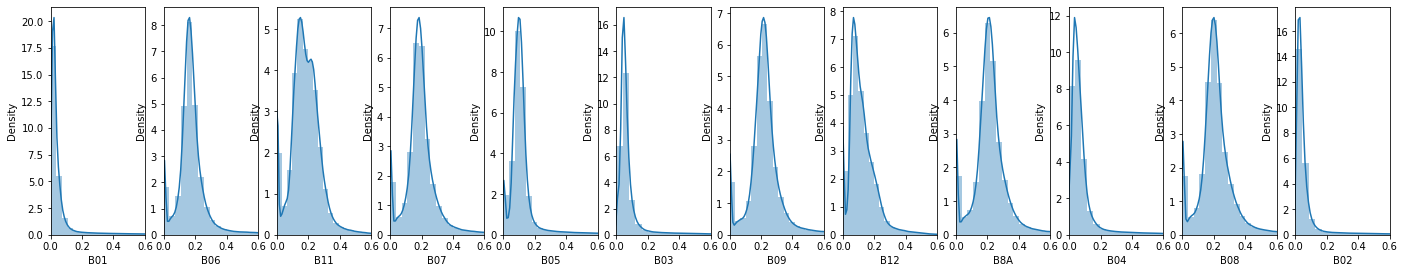

In [20]:
#Check skewness of Class 12
plot_class_distributions(12,0, 0.6)

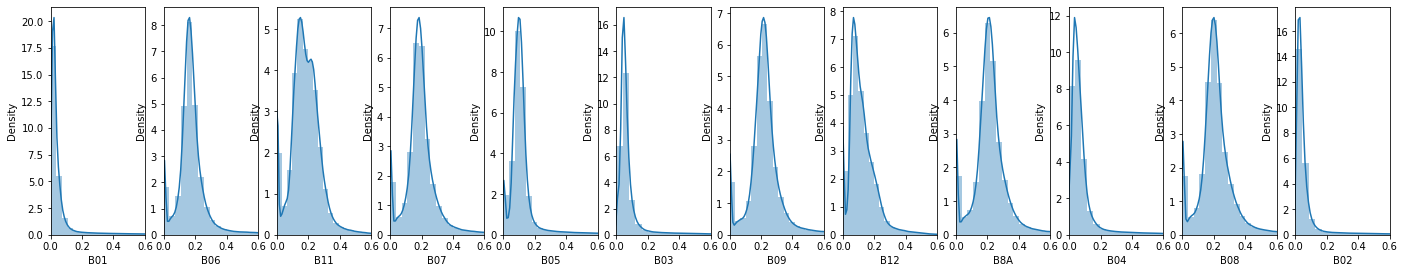

In [21]:
#Check skewness of Class 13
plot_class_distributions(13,0, 0.6)

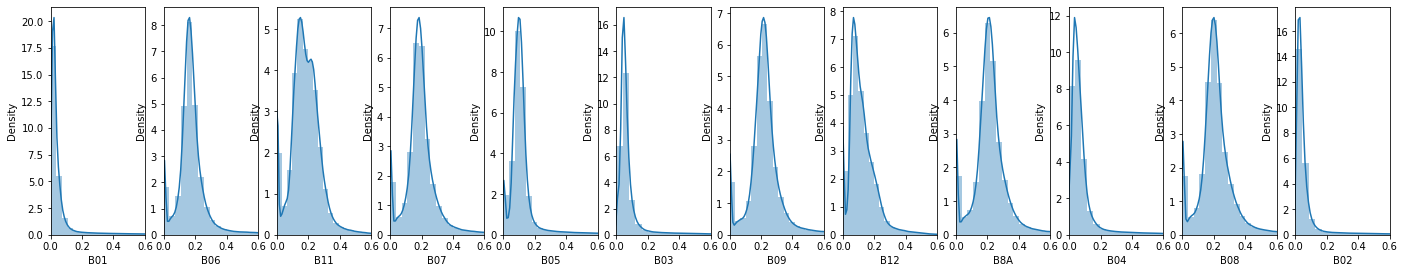

In [22]:
#Check skewness of Class 14
plot_class_distributions(14,0,0.6)

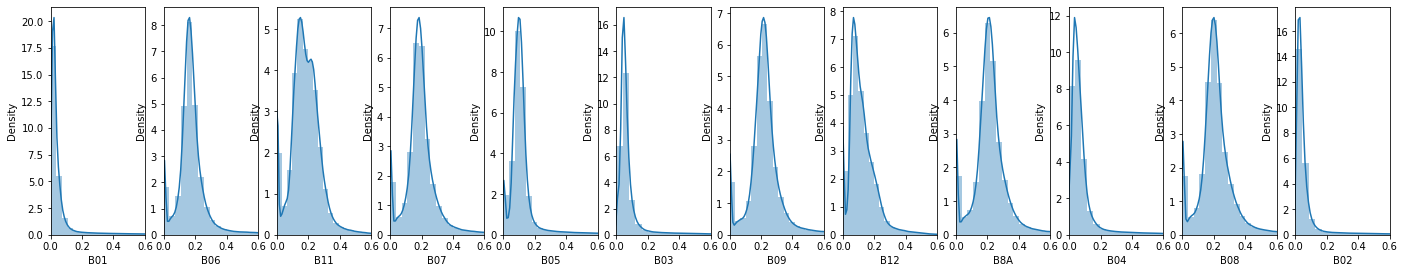

In [23]:
#Check skewness of Class 15
plot_class_distributions(15,0, 0.6)

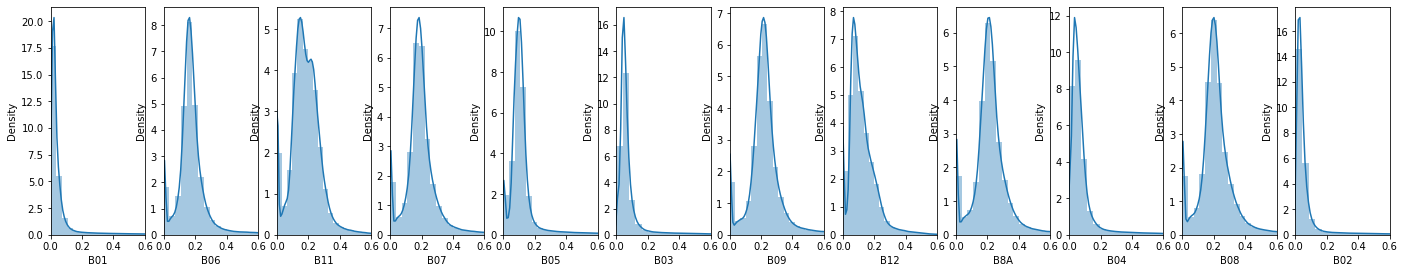

In [24]:
#Check skewness of Class 16
plot_class_distributions(16,0,0.6)

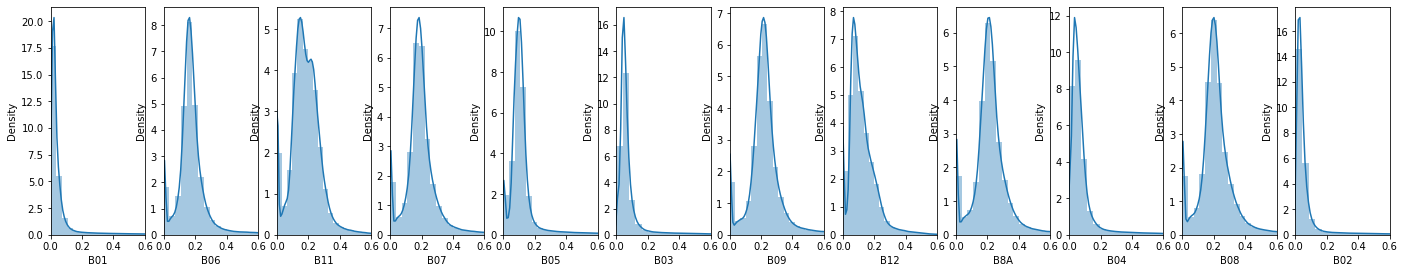

In [25]:
#Check skewness of Class 17
plot_class_distributions(17,0, 0.6)

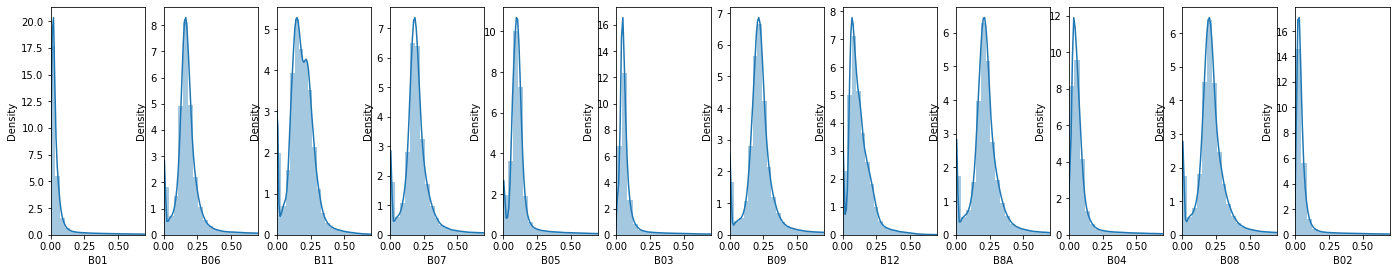

In [28]:
#Check skewness of Class 18
plot_class_distributions(18,0,0.7)

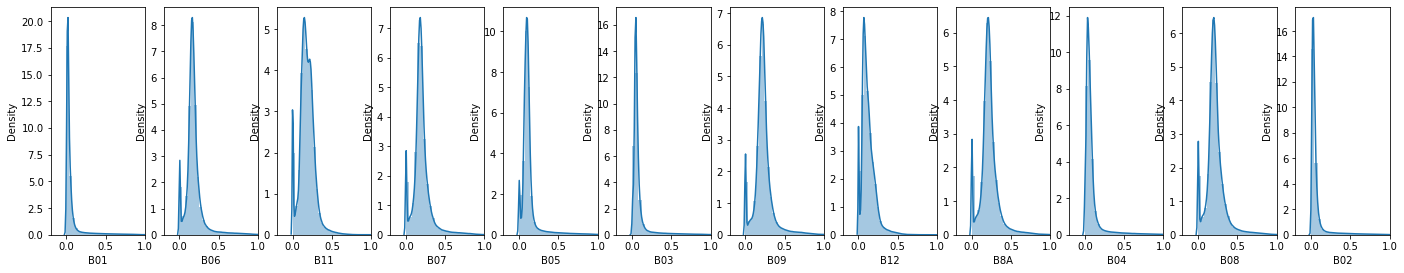

In [27]:
#Check skewness of Class 19
plot_class_distributions(19,-0.2,1)

# Other EDA

In [31]:
#Check describe
sample.describe()

,B01,B06,B11,B07,B05,B03,B09,B12,B8A,B04,B08,B02,Class
count,1.050000e+06,1.050000e+06,1.050000e+06,1.050000e+06,1.050000e+06,1.050000e+06,1.050000e+06,1.050000e+06,1.050000e+06,1.050000e+06,1.050000e+06,1.050000e+06,1.050000e+06
mean,6.609371e-02,1.837407e-01,1.829741e-01,2.018869e-01,1.290254e-01,8.904205e-02,2.293851e-01,1.228100e-01,2.229983e-01,9.141961e-02,2.203085e-01,7.227383e-02,1.113333e+01
std,1.317546e-01,1.250129e-01,9.821832e-02,1.226721e-01,1.317034e-01,1.333509e-01,1.269743e-01,8.929228e-02,1.220443e-01,1.349472e-01,1.277287e-01,1.357834e-01,5.512010e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,1.560000e-02,1.346000e-01,1.269000e-01,1.508000e-01,7.860000e-02,3.920000e-02,1.777000e-01,6.740000e-02,1.704000e-01,3.340000e-02,1.645000e-01,2.000000e-02,6.000000e+00
50%,2.580000e-02,1.667000e-01,1.759000e-01,1.875000e-01,1.030000e-01,5.270000e-02,2.182000e-01,1.035000e-01,2.131000e-01,5.530000e-02,2.061000e-01,3.390000e-02,1.200000e+01
75%,5.150000e-02,2.050000e-01,2.346000e-01,2.316000e-01,1.294000e-01,7.690000e-02,2.622000e-01,1.599000e-01,2.617000e-01,8.810000e-02,2.575000e-01,5.800000e-02,1.600000e+01
max,1.801500e+00,1.819500e+00,1.636200e+00,1.831300e+00,1.814500e+00,2.018700e+00,1.721000e+00,1.655900e+00,1.830200e+00,1.933800e+00,1.821300e+00,2.097400e+00,1.900000e+01


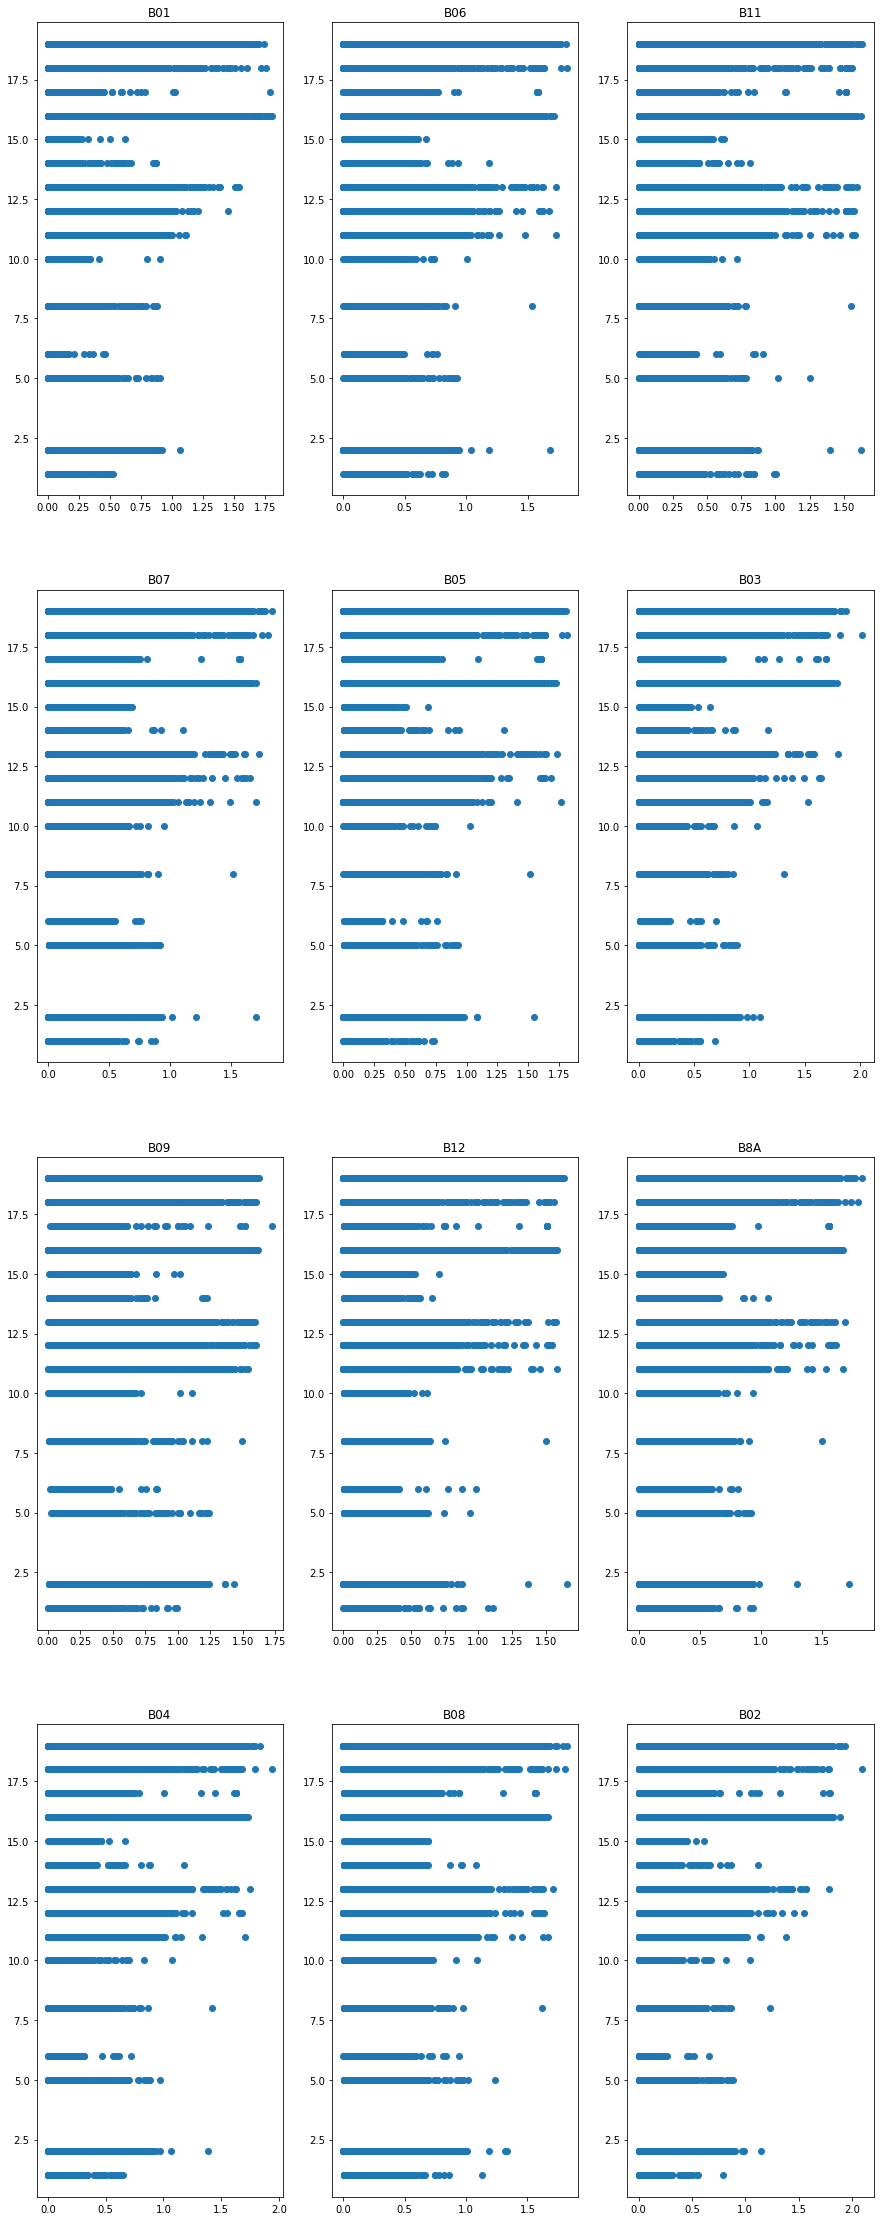

In [33]:
#Visulization of band distribution for each class in the main dataframe

#number of axes = number of possible combos
fig, axes = plt.subplots(4, 3, figsize = (15, 40))

for i, ax in enumerate(axes.flat):
    
    #index of columns
    X_scatter = sample[sample.columns[:-1][i]]
    Y_scatter = sample['Class']
    
    # scatter current combination
    ax.scatter(X_scatter, Y_scatter)
    ax.set_title(sample.columns[i])

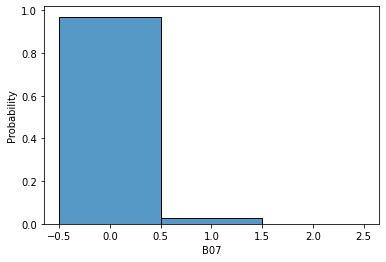

In [45]:
sns.histplot(data = sample, x = 'B07', stat = "probability", discrete = True)

In [35]:
from scipy.stats import zscore

y = sample.Class

sample.apply(zscore)
sample['Class'] = y

sample.head()

,B01,B06,B11,B07,B05,B03,B09,B12,B8A,B04,B08,B02,Class
0,0.0111,0.1854,0.1356,0.2248,0.0805,0.0440,0.2335,0.0641,0.2665,0.0426,0.2583,0.0207,1
1,0.0205,0.1824,0.1537,0.2040,0.1128,0.0543,0.2324,0.0823,0.2266,0.0591,0.2213,0.0368,1
2,0.0160,0.1272,0.1025,0.1449,0.0640,0.0334,0.1651,0.0543,0.1601,0.0251,0.1517,0.0212,1
3,0.0109,0.1250,0.0976,0.1408,0.0684,0.0337,0.1552,0.0502,0.1530,0.0282,0.1482,0.0227,1
4,0.0071,0.1320,0.0936,0.1451,0.0623,0.0324,0.1646,0.0463,0.1619,0.0236,0.1570,0.0180,1


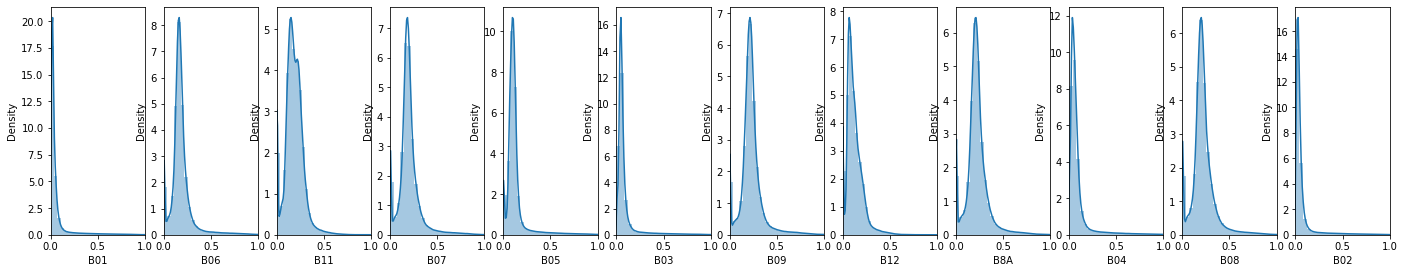

In [36]:
plot_class_distributions(1,0,1)

#Subsample and Save final csv

In [ ]:
#SubSample ~25 000 for each class
sample = merged_data.groupby('Class').apply(lambda x: x.sample(n=50000)).reset_index(drop=True)
sample.head(4)